## 02427 Advanced Time Series Analysis
### Computer exercise 1

In [349]:
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.arima_model 
from statsmodels.tsa.stattools import acf, pacf

from IPython.display import Markdown as md
import matplotlib.pyplot as plt

%matplotlib inline

Ensure reproducability

In [62]:
np.random.seed(seed=42)

### Part 1
We define number of simulations, input and white noise.

In [63]:
N = 1000
x = np.linspace(-1, 1, N)
r = np.random.randn(N)

We define a $\text{SETAR}(2, 1, 1)$ model, i.e. two regimes, delay 1 and auto-regressive order 1 (in both regimes).

In [142]:
def setar(x, r):
    assert len(x) == len(r)
    y = np.empty_like(r)
    y[0] = r[0]
    for t in range(1, len(x)):
        if y[t-1] < 120:
            y[t] = .25 + 1 * y[t-1] + r[t]
        else:
            y[t] = 110 + .1 * y[t-1] + r[t]
    return  y

We plot the time series. The model parameters define a ragime change when $y_{t - 1}$ gets above 120, triggering from a increasing state to a exausted state with strong constant value around $y = 122$.

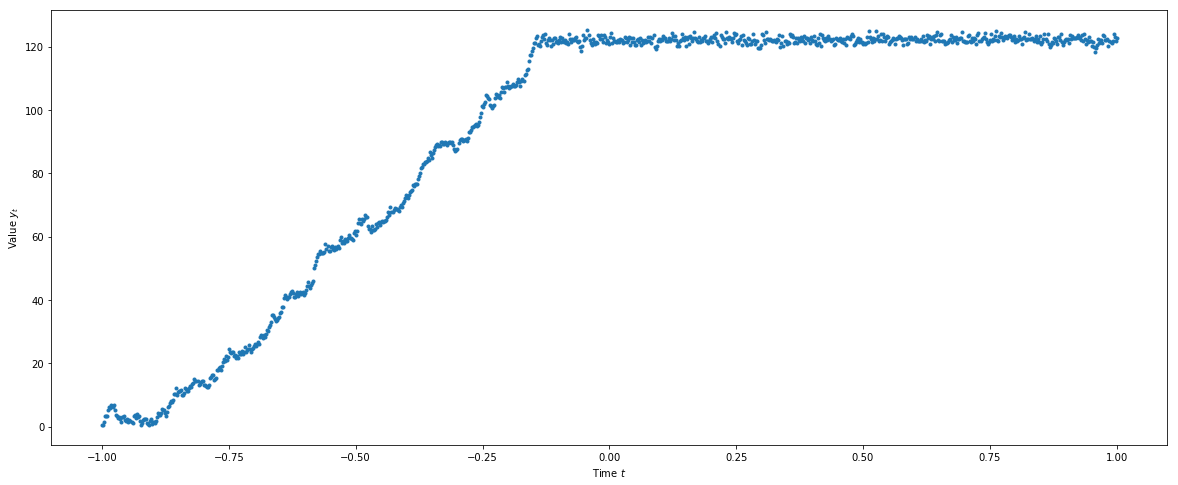

In [251]:
fig, ax = plt.subplots(figsize = (20, 8))
ax.set_xlabel(r'Time $t$')
ax.set_ylabel(r'Value $y_t$')
ax.plot(x, y_setar, marker = '.', linestyle = '')
None

In [143]:
y_setar = setar(x, r)

We try a MMAR(2, 1) models

**TODO**

We try a Kernal Regression model with bandwith $\gamma$.

**TODO**

### Part 2

We compute the theoretical conditional mean, $M(x) = E\left\{X_{t+1} \; | \; X_t = x\right\}$, for the $\text{SETAR}(2,1,1)$ model provided above.

We plot the contional mean as a function of .

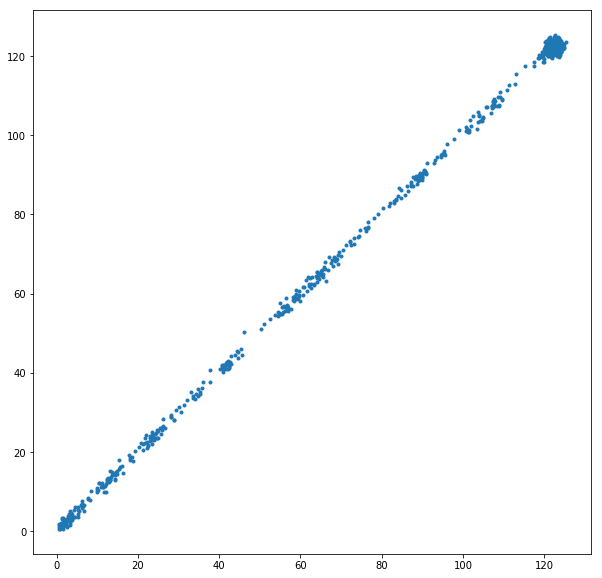

In [236]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(y_setar[:-1], y_setar[1:], linestyle = '', marker = '.')
#ax.plot(y_setar[:-1], y_setar[1:], linestyle = '', marker = '.')
None

**TODO**

We try different bandwidths and comments on our findings.

In [145]:
bws = np.arange(.1, .6, .1)
md("We use the folloing bandwidths: " + str(['%.1f' % bw for bw in bws]))

We use the folloing bandwidths: ['0.1', '0.2', '0.3', '0.4', '0.5']

We calculate local linear estimates given the different bandwidths:

In [146]:
lowess = [sm.nonparametric.lowess(y_setar, x, frac = bw, it = 0) for bw in bws]

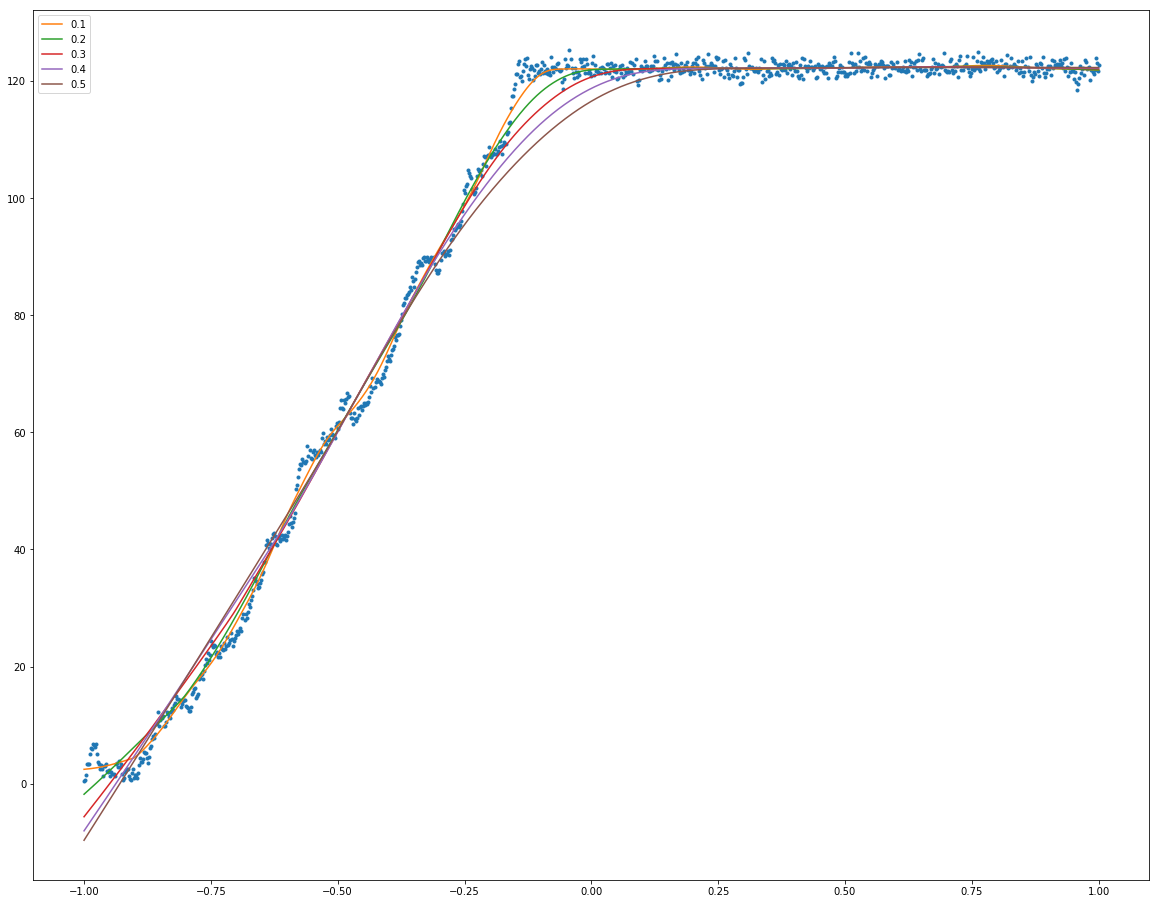

In [147]:
fig, ax = plt.subplots(figsize = (20, 16))
ax.plot(x, y_setar, marker = '.', linestyle = '')
for i in range(len(bws)):
    ax.plot(x, lowess[i][:, 1], marker = '', linestyle = '-', label = str(bws[i]))
ax.legend()
None

We see that 

### Part 3

Parameters for the histogram regression

In [182]:
## Number of intervals 
n_bins = 20
## The breaks between the intervals 
breaks = np.linspace(min(y_setar), max(y_setar), n_bins + 1)

In [183]:
## Initialize
h = np.diff(breaks)[0]
l = np.zeros(n_bins)
g = np.zeros(n_bins)
f_hat = np.zeros(n_bins)
h_hat = np.zeros(n_bins)

In [184]:
## Calc the hist regressogram, i.e. for each interval
for i in range(n_bins):
    x_bin = y_setar[(breaks[i] <= y_setar) & (y_setar < breaks[i+1])]
    assert(len(x_bin) > 5)
    l[i] = x_bin.mean()
    g[i] = np.sum((x_bin - l[i])**2) / len(x_bin)
    f_hat[i] = (n_bins*h)**(-1) * len(x_bin)    
    h_hat[i] = g[i]/f_hat[i];

In [185]:
L = (l*h).cumsum()
H_hat = (h_hat*h).cumsum();

In [186]:
## Make confidence bands for the cumulated function. Def. (3.10).
## 95% confidence band, c is found in table 3.1
c_alpha = 1.273

In [187]:
H_hat_b = H_hat[-1];
L_low = L - c_alpha * n_bins**(-0.5) * H_hat_b**(0.5) * (1 + H_hat/H_hat_b);
L_upr = L + c_alpha * n_bins**(-0.5) * H_hat_b**(0.5) * (1 + H_hat/H_hat_b);

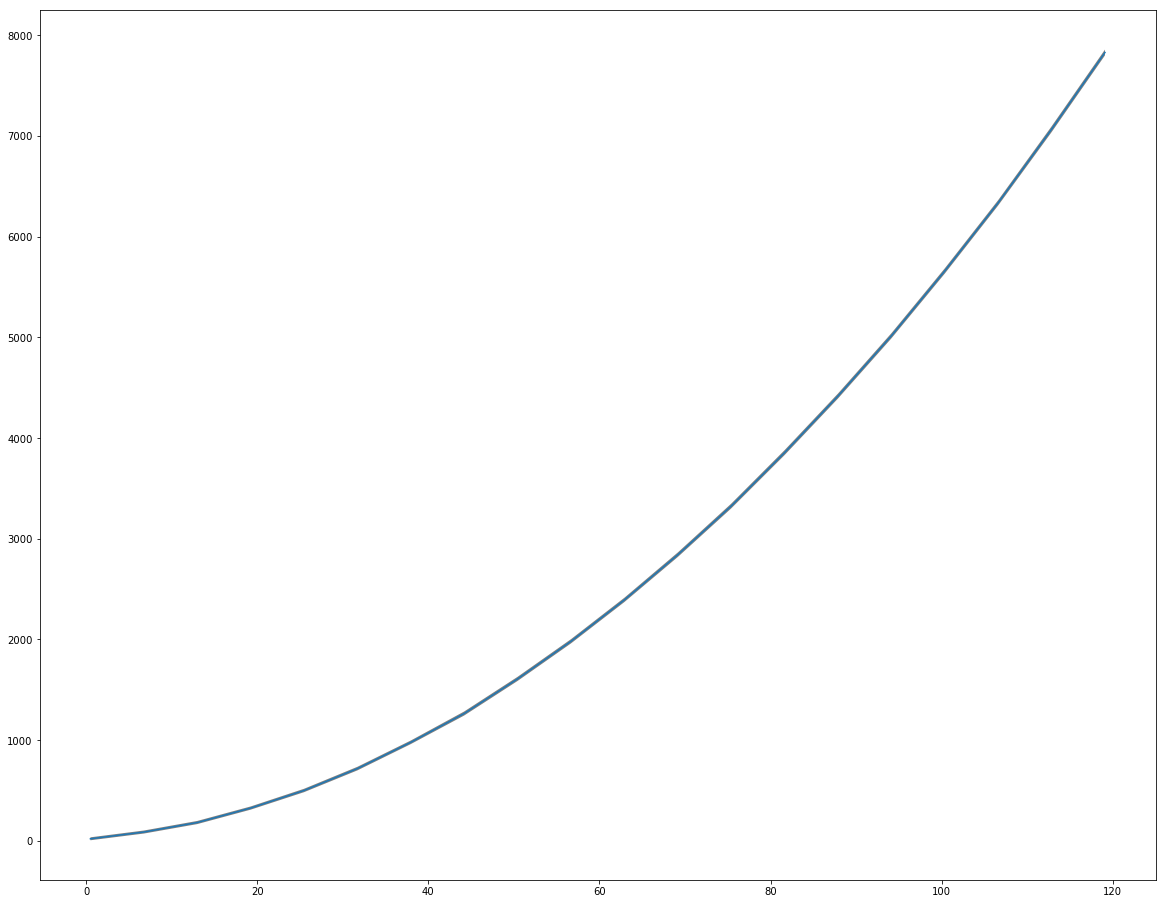

In [191]:
fig, ax = plt.subplots(figsize = (20, 16))
ax.fill_between(breaks[0:-1], L_low, L_upr,  facecolor='gray')
ax.plot(breaks[0:-1], L, marker = '', linestyle = '-')
None


### Part 4

We load the data:

In [197]:
data_heat = pd.read_csv('DataPart4.csv')
data_heat.head(5)

,Ph,Ti,Te,W
0,1496.970334,20.002530,12.255610,8.678768
1,1411.792178,19.957051,12.298405,7.185271
2,1368.595696,19.904727,12.576470,6.684292
3,1404.547674,19.886161,12.455047,7.702868
4,1376.436161,19.908530,12.638600,7.047383


Lets take a quick look at data. Visible strong correlation between $W$ and $T_e$, But also pattern in $T_i$ which seem to raise at night (?). We see a clear cyclic pattern.

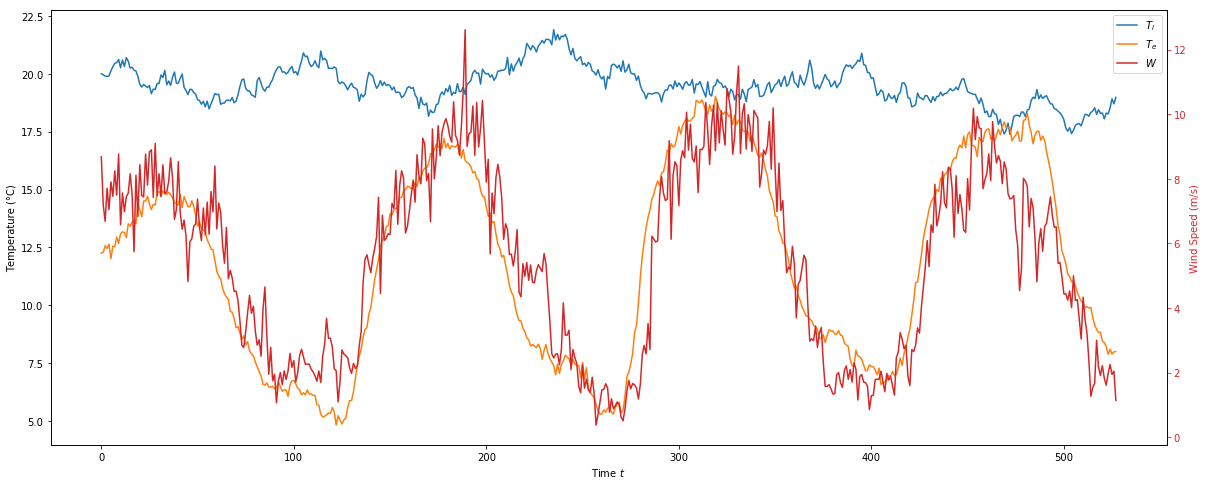

In [250]:
fig, ax = plt.subplots(figsize = (20, 8))
lns1 = ax.plot(data_heat['Ti'], label = r'$T_i$')
lns2 = ax.plot(data_heat['Te'], label = r'$T_e$')
ax.set_xlabel(r'Time $t$')
ax.set_ylabel('Temperature (°C)')
ax_sec = ax.twinx()
lns3 = ax_sec.plot(data_heat['W'], label = r'$W$', color = 'C3')
ax_sec.set_ylabel('Wind Speed (m/s)', color='C3')
ax_sec.tick_params('y', colors='C3')
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
None

Wee calculate and plot $U_a(W_t)$ and plot is both side by side with $W_t$ as a function of $t$ and as a function of $W_t$.

In [246]:
W = data_heat['W']
U_W = data_heat['Ph'] / (data_heat['Ti'] - data_heat['Te'])

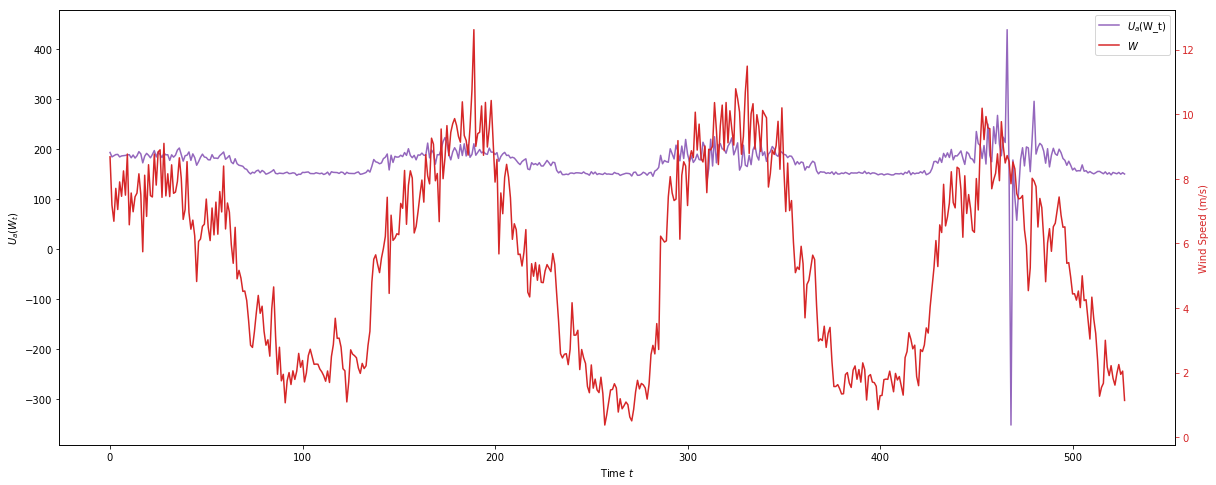

In [249]:
fig, ax = plt.subplots(figsize = (20, 8))
lns1 = ax.plot(U_W, label = r'$U_a($W_t$)$', color = 'C4')
ax.set_xlabel(r'Time $t$')
ax.set_ylabel(r'$U_a(W_t)$')
ax_sec = ax.twinx()
lns2 = ax_sec.plot(data_heat['W'], label = r'$W$', color = 'C3')
ax_sec.set_ylabel('Wind Speed (m/s)', color='C3')
ax_sec.tick_params('y', colors='C3')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
None

Wee still see the cyclic pattern, but now we see that $U_a(W_t)$ seems to have a lower limit around ~150 (unit?). We also see that the function has extreem values when $T_i < T_e$.

We fit LOEES model for $U_a(W_t) \sim W_t$ - this time implemented directly using linear regressen steps (using numpy's polyfit).

In [265]:
# Epanechnikov kernel
def ep_kernel(xall, x, h):
  ## Make the weights with an Epanechnikov kernel
  ## h has the same unit as x (i.e. it is on the same absolute scale, so if x is Watt, h is also given in Watt) 
  u = np.abs(xall - x)
  u = u / h
  w = 3/4 * (1 - u**2)
  ## Set values with |u|>1 to 0
  w[np.abs(u) > 1] = 0
  return w

In [304]:
hs = bws*(W.max() - W.min())
fit = np.empty([len(hs), len(W)])
fit[:,:] = np.nan
for i in range(len(W)):
    for j in range(len(hs)):
        w = ep_kernel(W, W[i], hs[j])
        coefs = poly.polyfit(x = W, y = U_W, deg = 1, w = w)
        fit[j, i] = poly.polyval(W[i], coefs)    

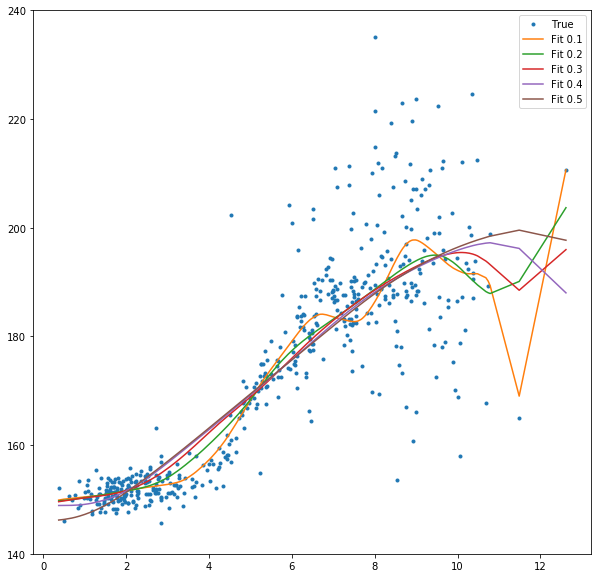

In [316]:
df = pd.DataFrame({'W': W, 'U_W': U_W})
for i in range(len(bws)):
    df['Fit %.1f' % bws[i]] = fit[i, :]
    
df = df.sort_values('W').reset_index(drop = True)

fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(df['W'], df['U_W'], linestyle = '', marker = '.', label = 'True')
for i in range(len(bws)):
    ax.plot(df['W'], df['Fit %.1f' % bws[i]], linestyle = '-', marker = '', label = 'Fit %.1f' % bws[i])
ax.set_ylim(140, 240)
ax.legend()
None

Just for comparison we estimate model using stat-models *lowess*-function. We get similar results, and difference it assumably because this uses a different kernel, and also some implementation/algoritm differences.

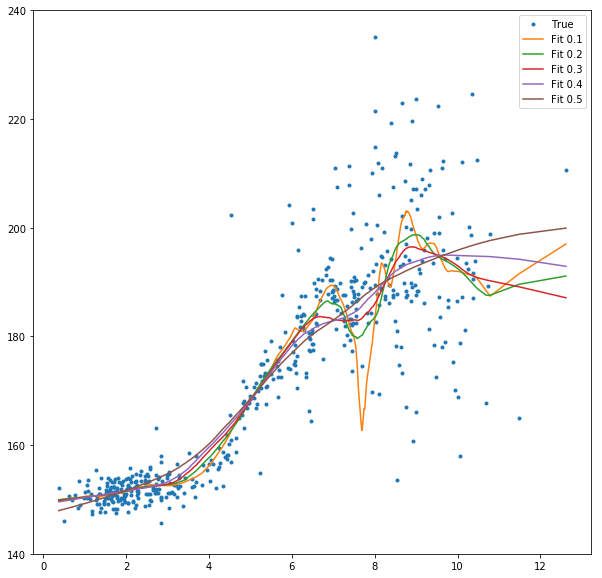

In [330]:
U_W_lowess = [sm.nonparametric.lowess(U_W, W, frac = bw, it = 0) for bw in bws]

df2 = pd.DataFrame({'W': W, 'U_W': U_W}).sort_values('W').reset_index(drop = True)

for i in range(len(bws)):
    df2['Fit %.1f' % bws[i]] = U_W_lowess[i][:,1]

fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(df2['W'], df2['U_W'], linestyle = '', marker = '.', label = 'True')
for i in range(len(bws)):
    ax.plot(df2['W'], df2['Fit %.1f' % bws[i]], linestyle = '-', marker = '', label = 'Fit %.1f' % bws[i])
ax.set_ylim(140, 240)
ax.legend()
None

### Part 5

We load the data:

In [332]:
data = pd.read_csv('DataPart5.csv')
data.head(5)

,x
0,0.000000
1,0.000000
2,0.043702
3,0.244185
4,0.228373


We take a quick look at the data (first 200 obs.)

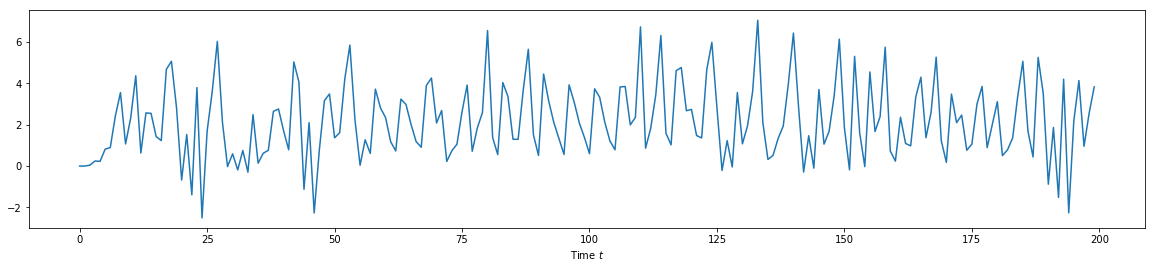

In [334]:
fig, ax = plt.subplots(figsize = (20, 4))
ax.set_xlabel(r'Time $t$')
ax.plot(data[:200])
None

We plot Autocorrelation and Partial Autocorrelation:

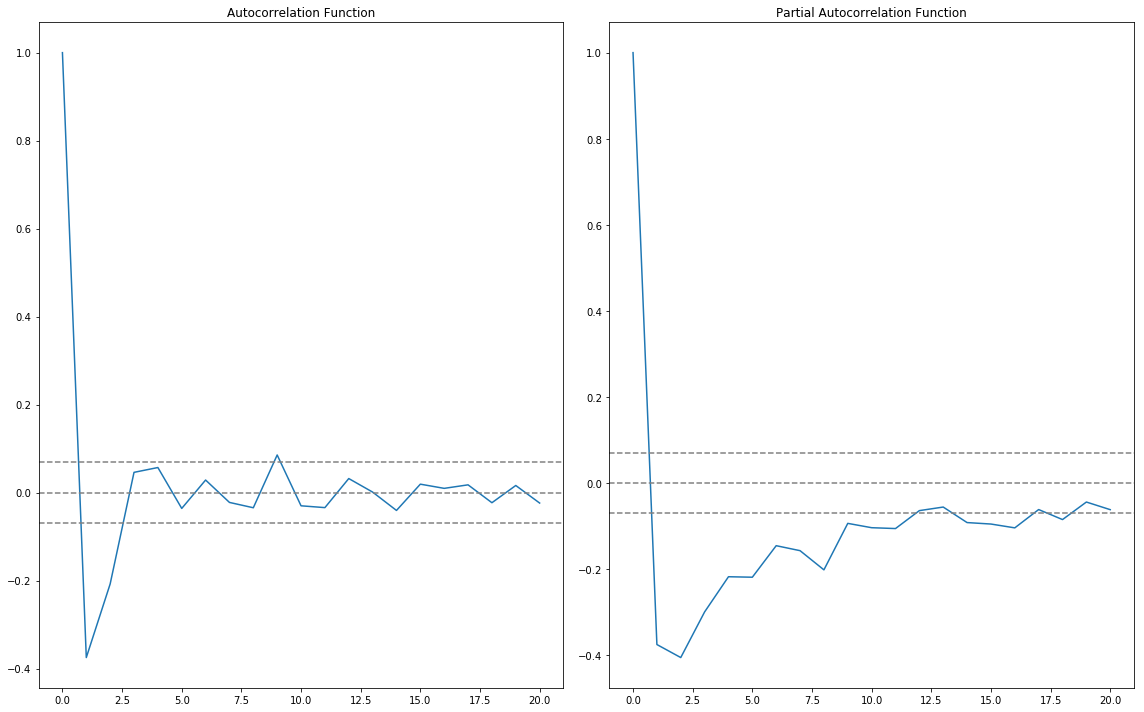

In [361]:
ts_diff = data['x'].values - data.shift(1)['x'].values
ts_diff = ts_diff[1:]
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')
fig, ax = plt.subplots(1, 2, figsize = (16, 10))
#Plot ACF: 
ax[0].plot(lag_acf)
ax[0].axhline(y=0,linestyle='--',color='gray')
ax[0].axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
ax[0].axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
ax[0].set_title('Autocorrelation Function')
#Plot PACF:
ax[1].plot(lag_pacf)
ax[1].axhline(y=0,linestyle='--',color='gray')
ax[1].axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
ax[1].axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
ax[1].set_title('Partial Autocorrelation Function')
fig.tight_layout()

Bassed on the above we choose $(p, q)$ = (4, 4)$ for our $\text{ARMA}(p, q)$-model. Also a higher values the inversion of the hassian-matrix fails.

In [367]:
arma = statsmodels.tsa.arima_model.ARMA(data['x'].values, order = (4, 4)).fit()

We plot the estimated values and residuals:

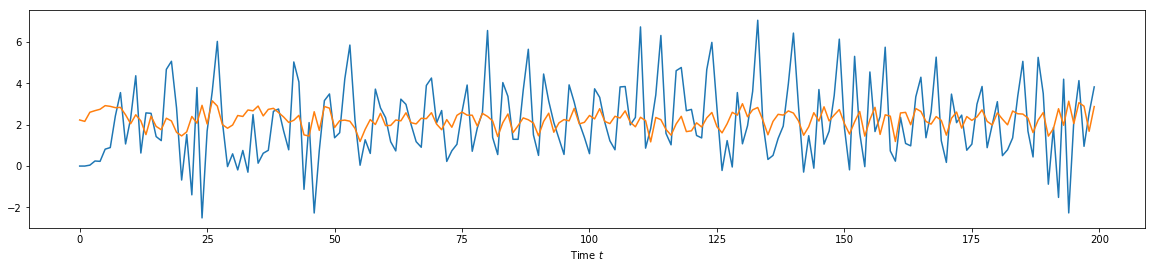

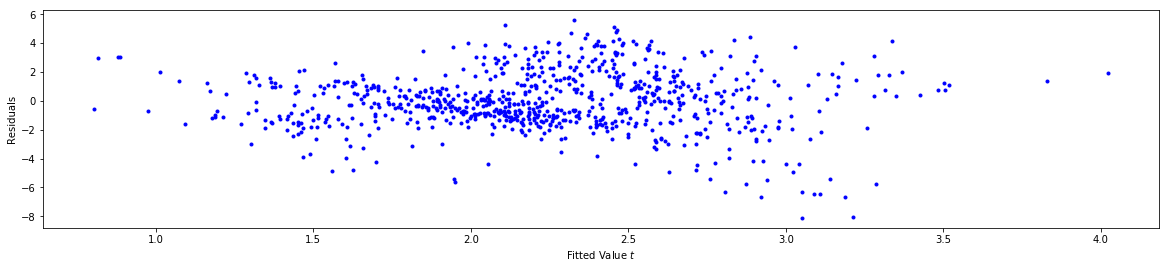

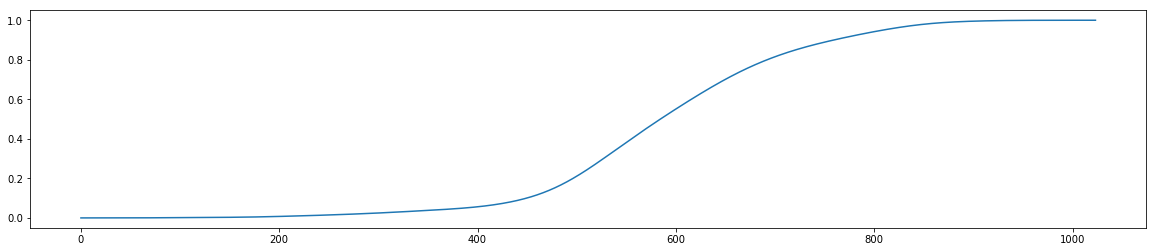

In [381]:
fig, ax = plt.subplots(figsize = (20, 4))
ax.set_xlabel(r'Time $t$')
ax.plot(data[:200])
ax.plot(arma.fittedvalues[:200])

resid = data['x'].values - arma.fittedvalues
fig, ax = plt.subplots(figsize = (20, 4))
ax.set_xlabel(r'Fitted Value $t$')
ax.set_ylabel(r'Residuals')
ax.plot(arma.fittedvalues, resid, color = 'b', marker = '.', linestyle='')

fig, ax = plt.subplots(figsize = (20, 4))
dens = sm.nonparametric.KDEUnivariate(resid)
dens.fit()
ax.plot(dens.cdf)

None